# Data Understanding and Preparation

Our goal is to ultimately develop a robust machine learning model that accurately predicts insurance premium amount ("Premium Amount")

## Data Understanding

In [35]:
# Hyperparameter tuning for XGBoost
from sklearn.model_selection import RandomizedSearchCV

# --- Version Check and Upgrade (for Google Colab) ---
print("Checking scikit-learn version...")
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
# scikit-learn version: 1.6.1

# Upgrade scikit-learn if necessary (uncomment if version is old)
# !pip install -U scikit-learn

print("Checking xgboost version...")
import xgboost
print(f"xgboost version: {xgboost.__version__}")

Checking scikit-learn version...
scikit-learn version: 1.4.2
Checking xgboost version...
xgboost version: 2.1.3


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np

In [3]:
# change to the appropriate filepath to the csv
GOOGLE_COLAB_FILE_DIR="/content/drive/MyDrive/school/AML/insurance_prediction.csv"

df = pd.read_csv("insurance_prediction.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [5]:
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [6]:
df["Policy Start Date"].head(20)

0     2023-12-23 15:21:39.134960
1     2023-06-12 15:21:39.111551
2     2023-09-30 15:21:39.221386
3     2024-06-12 15:21:39.226954
4     2021-12-01 15:21:39.252145
5     2022-05-20 15:21:39.207847
6     2020-02-21 15:21:39.219432
7     2022-08-08 15:21:39.181605
8     2020-12-14 15:21:39.198406
9     2020-08-02 15:21:39.144722
10    2021-05-12 15:21:39.134960
11    2020-03-22 15:21:39.155231
12    2021-10-28 15:21:39.086123
13    2023-01-20 15:21:39.132191
14    2021-08-14 15:21:39.233998
15    2020-10-17 15:21:39.209847
16    2024-04-22 15:21:39.255696
17    2020-12-27 15:21:39.090124
18    2021-10-13 15:21:39.094752
19    2020-06-25 15:21:39.152732
Name: Policy Start Date, dtype: object

We have a date column. Usually, these cannot be directly fed into the model, and additional feature engineering has to be done to the datetime. In this case, we can:

- Extract the day, month, year, dayofweek, quarter of the datetime.
> This can capture cyclical patterns

- Extract the days elapsed since the earliest date.
> This can capture temporal distance information.

This will allow the datetime to transform into a numerical feature that can be used in modelling.

In [7]:
# Calculate missing values
total_rows = len(df)
missing_stats = df.isnull().sum()

# Convert to percentage and filter columns with missing values
missing_stats = missing_stats[missing_stats > 0]
missing_pct = (missing_stats / total_rows * 100).round(1)

# Create a DataFrame with both counts and percentages
missing_df = pd.DataFrame(
    {"Missing Count": missing_stats, "Missing Percentage": missing_pct}
)

# Sort by missing percentage in descending order
missing_df = missing_df.sort_values("Missing Percentage", ascending=False)

# Format the output
print("Missing Value Analysis:")
print("-" * 60)
for idx, row in missing_df.iterrows():
    print(
        f"{idx:<20} has {int(row['Missing Count']):>6} ({row['Missing Percentage']:>4.1f}%) missing values"
    )

Missing Value Analysis:
------------------------------------------------------------
Previous Claims      has 364029 (30.3%) missing values
Occupation           has 358075 (29.8%) missing values
Credit Score         has 137882 (11.5%) missing values
Number of Dependents has 109672 ( 9.1%) missing values
Customer Feedback    has  77824 ( 6.5%) missing values
Health Score         has  74076 ( 6.2%) missing values
Annual Income        has  44949 ( 3.7%) missing values
Age                  has  18705 ( 1.6%) missing values
Marital Status       has  18529 ( 1.5%) missing values
Vehicle Age          has      6 ( 0.0%) missing values
Insurance Duration   has      1 ( 0.0%) missing values


There are large gaps in important information like Occupation, Credit Score and other factors.

Reasoning for Missing values are rarely random. For example, individuals from lower socioeconomic backgrounds might be less likely to provide detailed financial information, leading to higher proportion for missing values.

If these missing values are not addressed correctly, especially due to the large amount of missing values, this can lead to biased models that unfairly disadvantage certain groups. For example, An AI model trained on data with systematic missingness might learn "missing values" = "high risk".

One popular way to deal with missing values is imputation, which is the process of filling missing values. However, this can introduce its own biases. Simple methods like mean or median can distort the distribution of data. Imagine if Previous Claims' missing values was replaced with mean. The distribution would look like a normal distribution even though it, in reality, might not. More sophisticated methods like regression imputation or k-nearest neighbors can introduce complex dependencies that might not reflect reality.

In reality, the data scientist facing such an issue should communicate back with the data engineer and subject matter experts regarding the reasoning for missing values, and gain additional insights from there, which can potentially allow the data scientist to create interaction terms based on these insights for the model to learn.

After the data scientist create interaction terms, this step must be shared to increase the transparency of the model cleaning process. The company should have internal policies to document and store information in regards to model. Many insurance companies that treat their AI models as "black boxes" make it difficult to understand how decisions are made, eroding trust and making it challenging to identify biases.

For the purposes of this assignment, we assume that the data scientist was able to gain the insights to decide that **mean imputation** for numerical, and **mode imputation** for categorical, is the correct and fair way to address the issue.

In [8]:
# Calculate zero values
zero_stats = (df == 0).sum()
zero_pct = (zero_stats / total_rows * 100).round(1)

# Filter only numeric columns with zeros and create DataFrame
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
zero_df = pd.DataFrame(
    {"Zero Count": zero_stats[numeric_cols], "Zero Percentage": zero_pct[numeric_cols]}
)
zero_df = zero_df[zero_df["Zero Count"] > 0].sort_values(
    "Zero Percentage", ascending=False
)

# Format the output for zero values
print("\nZero Value Analysis:")
print("-" * 60)
for idx, row in zero_df.iterrows():
    print(
        f"{idx:<20} has {int(row['Zero Count']):>6} ({row['Zero Percentage']:>4.1f}%) zeros"
    )


Zero Value Analysis:
------------------------------------------------------------
Previous Claims      has 305433 (25.5%) zeros
Number of Dependents has 218124 (18.2%) zeros
Vehicle Age          has  61615 ( 5.1%) zeros
id                   has      1 ( 0.0%) zeros


While missing values signify non-response, system errors, or data entry omissions, Zero values represent explicit data points. It could mean that a customer had 0 previous claims, or a placeholder for "not applicable", which may explain the large amount of 0 previous claims.

Therefore, zero values have a high chance of being misinterpreted or mishandled by the various processes that the raw data goes through to get to the analysis stage. Zero values may be created from several reasons, and that needs to be checked by the data scientist, otherwise several ethical issues, like inaccurate predictions or unfair outcomes may occur, introducing bias and obscuring important information.

For the purposes of this assignment, we assume that the data scientist was able to gain the insights to check that all the zeros mean that the items are zero, for example, 0 previous claims, 0 dependents, vehicle is brand new.

This means that no actions are required to address the zeros.

In [9]:
# Specify the columns we want to analyze
categorical_cols = [
    "Gender",
    "Marital Status",
    "Number of Dependents",
    "Education Level",
    "Occupation",
    "Location",
    "Policy Type",
    "Customer Feedback",
    "Smoking Status",
    "Exercise Frequency",
    "Property Type",
]

# Display distribution for each specified variable
print("\nCategorical Variables Distribution:")
print("-" * 80)
for col in categorical_cols:
    value_counts = df[col].value_counts()
    percentages = (value_counts / len(df) * 100).round(1)

    # Sort by percentage in descending order
    percentages = percentages.sort_values(ascending=False)
    value_counts = value_counts[percentages.index]

    print(f"\n{col}:")
    print("-" * 70)

    # Calculate max value length for alignment
    max_val_length = max(len(str(val)) for val in value_counts.index)

    # Create visual representation
    for val, count in value_counts.items():
        pct = percentages[val]
        bar_length = int(pct / 2)  # Scale bar length (50 = full width)
        bar = "█" * bar_length
        print(f"{str(val):<{max_val_length+2}} : {count:>7} ({pct:>4.1f}%) {bar}")

    # Add distribution indicator
    unique_vals = len(value_counts)
    max_pct = percentages.max()
    min_pct = percentages.min()
    pct_range = max_pct - min_pct

    if unique_vals <= 5 and pct_range < 10:
        print(
            f"{'★ EVEN DISTRIBUTION ★':>{max_val_length+2}} : max-min spread = {pct_range:.1f}%"
        )
    print()



Categorical Variables Distribution:
--------------------------------------------------------------------------------

Gender:
----------------------------------------------------------------------
Male     :  602571 (50.2%) █████████████████████████
Female   :  597429 (49.8%) ████████████████████████
★ EVEN DISTRIBUTION ★ : max-min spread = 0.4%


Marital Status:
----------------------------------------------------------------------
Single     :  395391 (32.9%) ████████████████
Married    :  394316 (32.9%) ████████████████
Divorced   :  391764 (32.6%) ████████████████
★ EVEN DISTRIBUTION ★ : max-min spread = 0.3%


Number of Dependents:
----------------------------------------------------------------------
3.0   :  221475 (18.5%) █████████
4.0   :  220340 (18.4%) █████████
0.0   :  218124 (18.2%) █████████
2.0   :  215313 (17.9%) ████████
1.0   :  215076 (17.9%) ████████
★ EVEN DISTRIBUTION ★ : max-min spread = 0.6%


Education Level:
--------------------------------------------------

All categorical variables are extremely even. Statistically speaking, this is improbable in real-world data. This strongly suggest that this is synthetic or artificially balanced data. Synthetic data is useful in educational sense, where students are expected to apply machine learning models to it and return relevant AI ethics info, but in the real world, synthetic data must be labelled clearly, like 'synthetic_insurance_prediction.csv'.


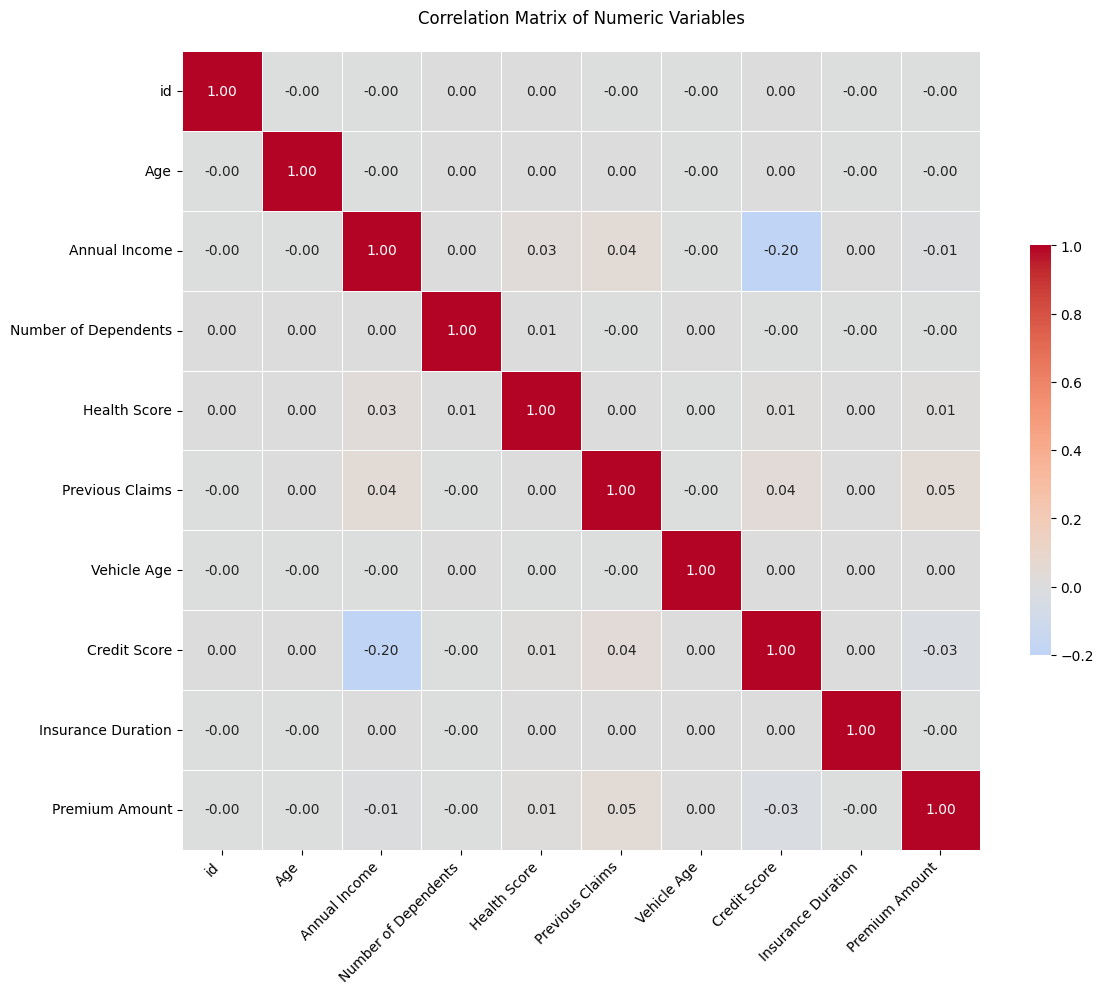

In [10]:
# Create correlation matrix plot
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_cols].corr()

# Create a larger figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix,
            annot=True,            # Show correlation values
            cmap='coolwarm',       # Color scheme
            center=0,              # Center the colormap at 0
            fmt='.2f',            # Format correlation values to 2 decimal places
            square=True,           # Make cells square
            linewidths=0.5,        # Add grid lines
            cbar_kws={"shrink": .5}) # Adjust colorbar size

plt.title('Correlation Matrix of Numeric Variables', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Signs of poor data:
- Highest correlation is between Credit Score and Annual Income. This indicates possible multicollinearity
- Looking at the rightmost column, we see that Premium Amount has very weak correlation with the rest of variables. the most is "Previous Claims", which is r=0.05. This indicates features that are not important to the target variable of "Premium Amount".

The  signs of poor data are looking at the linear correlation of features and our target variable. While they may not capture non-linear relationships, we are not building a Deep Learning Model that can capture complex relationships. These bad signs mean that models will perform badly.

In [11]:
# Statistical Summary for Numeric Variables
print("\nStatistical Summary of Numeric Variables:")
print("-" * 80)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
stats_df = df[numeric_cols].describe()
print(stats_df.round(2))

# Check for outliers using IQR method
print("\nOutlier Analysis using IQR method:")
print("-" * 80)
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if len(outliers) > 0:
        print(f"\n{col}:")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {(len(outliers)/len(df)*100):.2f}%")
        print(f"Range of outliers: {outliers.min():.2f} to {outliers.max():.2f}")



Statistical Summary of Numeric Variables:
--------------------------------------------------------------------------------
               id         Age  Annual Income  Number of Dependents  \
count  1200000.00  1181295.00     1155051.00            1090328.00   
mean    599999.50       41.15       32745.22                  2.01   
std     346410.31       13.54       32179.51                  1.42   
min          0.00       18.00           1.00                  0.00   
25%     299999.75       30.00        8001.00                  1.00   
50%     599999.50       41.00       23911.00                  2.00   
75%     899999.25       53.00       44634.00                  3.00   
max    1199999.00       64.00      149997.00                  4.00   

       Health Score  Previous Claims  Vehicle Age  Credit Score  \
count    1125924.00        835971.00   1199994.00    1062118.00   
mean          25.61             1.00         9.57        592.92   
std           12.20             0.98        

We have some outliers in Annual Income and Premium Amount. Outliers can either reflect genuine anomalies, or be the result of errors, biases ow unique circumstances. One thing that is certain is that outliers will skew the model's understanding of the underlying relationships between variables.

In the worst case scenario, the outliers are misleading, and it for example, learns the few individuals with high incomes and overestimate the incomes, leading to inaccuracy and unfair pricing. Outliers can also introduce bias. If the outliers are more prevalent in certain demographic groups, the model might unfairly penalize individuals from those groups.

looking at the number, percentage and range of outliers, it seems like these numbers can be rather reasonable.

1. **Annual Income (99,584 to 149,997)**
- The range appears reasonable because:
  - The median income is 23,911
  - High-income individuals earning 100K-150K annually is plausible
  - The upper limit of ~150K suggests the data might be capped, which is a common practice
  - The 5.59% proportion of outliers is within a reasonable range (typically <10% is acceptable)

2. **Previous Claims (6 to 9)**
- This range needs careful consideration:
  - Having 6-9 previous claims is unusually high
  - But Only 0.03% of customers fall in this range (369 cases out of 835,971)
  - These could be:
    - High-risk customers
    - Potential fraud cases

3. **Premium Amount (3,002 to 4,999)**
- This range appears reasonable because:
  - The median premium is 872
  - Higher premiums (3K-5K) could correspond to:
    - High-risk customers
    - Comprehensive coverage
    - Luxury vehicles
    - Multiple vehicles/policies
  - The 4.11% proportion is reasonable
  - The upper limit of 4,999 suggests a policy cap


In [12]:
# Analyze premium distribution for high-claim customers
high_claims_premium = df[df['Previous Claims'] >= 6]['Premium Amount']
print("\nPremium Distribution for High-Claim Customers:")
print(high_claims_premium.describe())


Premium Distribution for High-Claim Customers:
count     369.000000
mean     1357.542005
std       986.236891
min        20.000000
25%       603.000000
50%      1127.000000
75%      1878.000000
max      4955.000000
Name: Premium Amount, dtype: float64


Previous claims of more than or equal to 6 show very high premium distribution. It is reasonable to think that those with abnormally high previous claims also have abnormally high premium amount. 

In [13]:
# Analyze premium distribution for high-claim customers
high_income_premium = df[df['Annual Income'] >= 99_584]['Premium Amount']
print("\nPremium Distribution for High-Income Customers:")
print(high_income_premium.describe())


Premium Distribution for High-Income Customers:
count    67132.000000
mean      1129.699577
std       1049.661428
min         20.000000
25%        272.000000
50%        782.000000
75%       1839.000000
max       4988.000000
Name: Premium Amount, dtype: float64


Annual income also show high premium distribution.

Let's take a look at the sorted dataframe from premium amount descending.

In [14]:
df[["Annual Income", "Previous Claims", "Premium Amount"]].sort_values("Premium Amount", ascending=False).head(20)

,Annual Income,Previous Claims,Premium Amount
848669,14900.0,0.0,4999.0
767167,38988.0,0.0,4997.0
877994,79801.0,NaN,4997.0
1169248,8440.0,0.0,4996.0
75643,23435.0,NaN,4994.0
556721,38517.0,NaN,4992.0
1045482,2914.0,NaN,4991.0
956262,NaN,3.0,4988.0
632117,27365.0,5.0,4988.0
310362,100038.0,1.0,4988.0


It looks like Annual Income and Previous Claims has no real correlation with Premium Amount. This is strange because in real-life, these should be highly correlated.

### Annual Income vs Premium Amount
Typically, the income should correlate because higher income individuals tend to insure more valuable assets, and higher income individuals often opt for more comprehensive coverage.

### Previous Claims vs Premium Amount
Typically, the previous claims should correlate because more claims typically lead to higher premiums, and the industry standard practice is to incerase premiums after claims. https://www.investopedia.com/articles/pf/08/claim-raise-rates.asp#:~:text=Filing%20a%20claim%20often%20results,can%20vary%20widely%20between%20insurers.

This points to data quality issues. Not only is the data synthetic, but also is problematic because it doesn't reflect reality. 

In [15]:
# Check for skewness
print("\nSkewness Analysis:")
print("-" * 80)
skewness = df[numeric_cols].skew()
print("\nSkewness of numeric variables:")
for col, skew in skewness.items():
    print(f"{col:<20}: {skew:>8.2f} {'(Highly Skewed)' if abs(skew) > 1 else '(Moderately Skewed)' if abs(skew) > 0.5 else '(Approximately Symmetric)'}")


Skewness Analysis:
--------------------------------------------------------------------------------

Skewness of numeric variables:
id                  :     0.00 (Approximately Symmetric)
Age                 :    -0.01 (Approximately Symmetric)
Annual Income       :     1.47 (Highly Skewed)
Number of Dependents:    -0.01 (Approximately Symmetric)
Health Score        :     0.28 (Approximately Symmetric)
Previous Claims     :     0.91 (Moderately Skewed)
Vehicle Age         :    -0.02 (Approximately Symmetric)
Credit Score        :    -0.11 (Approximately Symmetric)
Insurance Duration  :    -0.01 (Approximately Symmetric)
Premium Amount      :     1.24 (Highly Skewed)


Given the outliers, Annual Income, Previous Claims and Premium Amount are highly left-skewed.

We may use scaling. One approach is to use scaling for SVM and Linear regression related algorithms, but not for tree-based models like random forest, decision tree, XGBoost.

This is because Tree-based models make decisions based of splitting points, not distances or gradients. They ask yes/no questions about features, regardless of their scale. For example, "Is Annual Income <= $45k?".

For linear and SVM, they use mathematical operations or distance calculations, and are scale-dependent.

Therefore, we shall address the left-skewness with np.log1p (logarithm plus 1), which will handle zero values and stretch the concentrated left side of the distribution.


## Data preparation


In [16]:
# Handle datetime features
datetime_cols = ["Policy Start Date"]
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])
for col in datetime_cols:
    # Extract useful datetime components
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_dayofweek'] = df[col].dt.dayofweek
    df[f'{col}_quarter'] = df[col].dt.quarter
    
    # Calculate days since earliest date
    df[f'{col}_days_since_min'] = (df[col] - df[col].min()).dt.days
    
    # Drop original datetime column
    df = df.drop(columns=[col])
df

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day,Policy Start Date_dayofweek,Policy Start Date_quarter,Policy Start Date_days_since_min
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,No,Weekly,House,2869.0,2023,12,23,5,4,1589
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,Yes,Monthly,House,1483.0,2023,6,12,0,2,1395
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,Yes,Weekly,House,567.0,2023,9,30,5,3,1505
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,Yes,Daily,Apartment,765.0,2024,6,12,2,2,1761
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,Yes,Weekly,House,2022.0,2021,12,1,2,4,837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,...,No,Daily,Apartment,1303.0,2023,5,3,2,2,1355
1199996,1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,...,No,Weekly,Apartment,821.0,2022,9,10,5,3,1120
1199997,1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,...,No,Monthly,Condo,371.0,2021,5,25,1,2,647
1199998,1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,...,No,Daily,Apartment,596.0,2021,9,19,6,3,764


In [17]:
df["Number of Dependents"].value_counts()

Number of Dependents
3.0    221475
4.0    220340
0.0    218124
2.0    215313
1.0    215076
Name: count, dtype: int64

We need to be wary of Number of Dependents because it detects the column as a int64 even though its categorical

In [18]:
for col in df.columns:
    if df[col].isnull().any():
        if col == "Number of Dependents":
            # Use mode for 'Number of Dependents'
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
        elif df[col].dtype in ["int64", "float64"]:
            # Use mean for numerical columns
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val)
        else:
            # Use mode (most frequent value) for categorical columns
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)

In [19]:
df["Number of Dependents"].value_counts()

Number of Dependents
3.0    331147
4.0    220340
0.0    218124
2.0    215313
1.0    215076
Name: count, dtype: int64

In [20]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### Why drop_first=True?
The `drop_first=True` argument in `pd.get_dummies` is used to address multicollinearity that arises from one-hot encoding categorical variables, specifically the "dummy variable trap".

Here's how it works and when you should consider using it:

**How `drop_first=True` Impacts Multicollinearity:**

* **Without `drop_first=True`:** When you one-hot encode a categorical variable with *k* categories, `pd.get_dummies` creates *k* binary columns.  For example, if you have a "Color" column with categories "Red", "Blue", and "Green", it will create three columns: "Color_Red", "Color_Blue", and "Color_Green".  In this scenario, if a row is *not* "Red" and *not* "Blue", you can perfectly infer that it *must* be "Green". This means the "Color_Green" column is perfectly predictable from the other two. This perfect predictability leads to **perfect multicollinearity**.

* **With `drop_first=True`:**  `drop_first=True` tells `pd.get_dummies` to drop the *first* category's column. In our "Color" example, if it drops "Color_Red", you'll be left with "Color_Blue" and "Color_Green". Now, if both "Color_Blue" and "Color_Green" are 0, you can still infer that the color is "Red" (the dropped category).  However, you've removed the perfect linear dependency. You have reduced the number of columns to *k-1*, which is sufficient to represent the information without creating perfect multicollinearity.


In [21]:
# Log transform skewed numerical features
skewed_cols = ["Annual Income", "Previous Claims", "Premium Amount"]
log_cols = ["Log Annual Income", "Log Previous Claims", "Log Premium Amount"]

# Create new log-transformed columns while preserving originals
for orig_col, new_col in zip(skewed_cols, log_cols):
    df[new_col] = np.log1p(df[orig_col])

# Print skewness before and after transformation
print("\nSkewness before and after log transformation:")
print("-" * 60)
for orig_col, new_col in zip(skewed_cols, log_cols):
    orig_skew = df[orig_col].skew()
    new_skew = df[new_col].skew()
    print(f"{orig_col:<20}: {orig_skew:>8.2f}")
    print(f"{new_col:<20}: {new_skew:>8.2f}\n")


Skewness before and after log transformation:
------------------------------------------------------------
Annual Income       :     1.50
Log Annual Income   :    -1.06

Previous Claims     :     1.08
Log Previous Claims :    -0.16

Premium Amount      :     1.24
Log Premium Amount  :    -1.26



log transformation, some of our variables have become negatively skewed, which isn't ideal. Let's try using Box-Cox transformation instead, which can help normalize the data while potentially avoiding negative skewness.

In [22]:
# 3. Transform skewed numerical features using Box-Cox
from scipy import stats

skewed_cols = ["Annual Income", "Previous Claims", "Premium Amount"]
box_cols = ["Transformed Annual Income", "Transformed Previous Claims", "Transformed Premium Amount"]

# Create new transformed columns while preserving originals
for orig_col, new_col in zip(skewed_cols, box_cols):
    # Add a small constant to handle zeros before Box-Cox
    min_val = df[orig_col].min()
    if min_val <= 0:
        shifted_data = df[orig_col] + abs(min_val) + 1
    else:
        shifted_data = df[orig_col]
    
    # Apply Box-Cox transformation
    transformed_data, lambda_param = stats.boxcox(shifted_data)
    df[new_col] = transformed_data

# Print skewness before and after transformation
print("\nSkewness before and after Box-Cox transformation:")
print("-" * 60)
for orig_col, new_col in zip(skewed_cols, box_cols):
    orig_skew = df[orig_col].skew()
    new_skew = df[new_col].skew()
    print(f"{orig_col:<20}: {orig_skew:>8.2f}")
    print(f"{new_col:<20}: {new_skew:>8.2f}\n")


Skewness before and after Box-Cox transformation:
------------------------------------------------------------
Annual Income       :     1.50
Transformed Annual Income:    -0.08

Previous Claims     :     1.08
Transformed Previous Claims:    -0.01

Premium Amount      :     1.24
Transformed Premium Amount:    -0.06



The reason why Box-Cox works, is because it is driven by a formular that finds the optimal λ (lambda) parameter for each variable.
This lamba affects the transformation process of the variables in this way:

- λ = 1 means no transformation needed
- λ = 0.5 means square root transformation
- λ = -1 means reciprocal transformation

Therefore, it mathematically optimizes for normality. That's why we see much better normalization results. It's like choosing the perfect power transformation for each variable's distribution pattern.

In [23]:
# since box-cox returns more normal values, let's drop log columns
for col in log_cols:
    df.drop(col, inplace=True, axis="columns")

## Feature engineering

Our feature engineering approach will be split into two phases:

1. First Phase - Tree-based Models:
   - We'll use the original features (including one-hot encoded categoricals)
   - Tree-based models (Random Forest, XGBoost) can:
     - Handle non-linear relationships naturally
     - Work well with raw features
     - Provide feature importance rankings
     - Are interpretable with original features

2. Second Phase - Linear & SVM Models:
   - After tree-based models, we'll apply PCA and Log1p because:
     - Linear/SVM models are sensitive to multicollinearity
     - PCA removes correlations between features
     - Reduces dimensionality, especially important with our many one-hot encoded columns
     - Can improve model performance by removing noise

This two-phase approach maintains interpretability where possible (tree-based) while optimizing performance where needed (linear/SVM).


## Model Selection & Evaluation

### Tree-based models

We'll evaluate three tree-based models:
1. Random Forest: Robust against overfitting, handles non-linear relationships
2. XGBoost: Typically highest performance, gradient boosting approach
3. Decision Tree: Baseline model, highly interpretable

Key considerations for our insurance premium prediction:
- High-dimensional data after one-hot encoding
- Potential non-linear relationships between features
- Need for both performance and interpretability
- Presence of outliers in key features

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import time
from tqdm.auto import tqdm
import lightgbm as lgb

# Prepare features and target
# Exclude log-transformed columns and datetime columns for tree-based models
feature_cols = [
    col
    for col in df.columns
    if col not in ["Premium Amount"] + box_cols
    and df[col].dtype
]
X = df[feature_cols]
y = df["Premium Amount"]

# Print feature columns being used
print("\nFeatures being used:")
print("-" * 80)
for col in feature_cols:
    print(f"{col}: {df[col].dtype}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize models
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)
rf_model = RandomForestRegressor(
    n_estimators=50, random_state=42, max_depth=5, n_jobs=-1
)
xgb_model = xgb.XGBRegressor(
    random_state=42, n_estimators=50, max_depth=5, n_jobs=-1, tree_method="hist"
)
light_model = lgb.LGBMRegressor(
    random_state=42, n_estimators=50, max_depth=5, n_jobs=-1, boosting_type="gbdt"
)
SPLITS = 3
kf = KFold(n_splits=SPLITS, shuffle=True, random_state=42)

# Dictionary to store model results
model_results = {}


Features being used:
--------------------------------------------------------------------------------
id: int64
Age: float64
Annual Income: float64
Health Score: float64
Previous Claims: float64
Vehicle Age: float64
Credit Score: float64
Insurance Duration: float64
Policy Start Date_year: int32
Policy Start Date_month: int32
Policy Start Date_day: int32
Policy Start Date_dayofweek: int32
Policy Start Date_quarter: int32
Policy Start Date_days_since_min: int64
Gender_Male: bool
Marital Status_Married: bool
Marital Status_Single: bool
Number of Dependents_1.0: bool
Number of Dependents_2.0: bool
Number of Dependents_3.0: bool
Number of Dependents_4.0: bool
Education Level_High School: bool
Education Level_Master's: bool
Education Level_PhD: bool
Occupation_Self-Employed: bool
Occupation_Unemployed: bool
Location_Suburban: bool
Location_Urban: bool
Policy Type_Comprehensive: bool
Policy Type_Premium: bool
Customer Feedback_Good: bool
Customer Feedback_Poor: bool
Smoking Status_Yes: bool


In [25]:
X_train.shape

(960000, 38)

In [26]:
# Dictionary to store model results
model_results = {}

# Train and evaluate each model
for name, model in tqdm(
    [
        ("Decision Tree", dt_model),
        ("XGBoost", xgb_model),
        ("LightGBM", light_model),
        ("Random Forest", rf_model),
    ],
    desc="Training Models",
):
    print(f"\nTraining {name}...")

    start_time = time.time()
    with tqdm(desc=f"Training {name}", leave=False) as pbar:
        model.fit(X_train, y_train)
    end_time = time.time()
    duration = end_time - start_time
    print(f"{name} training completed in {duration:.2f} seconds")

    # Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Perform cross-validation with progress bar
    print("Performing cross-validation...")
    cv_scores = []

    for train_idx, val_idx in tqdm(kf.split(X), desc=f"{name} CV", total=SPLITS):
        X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
        y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train and evaluate
        start_time = time.time()
        model.fit(X_cv_train, y_cv_train)
        end_time = time.time()
        duration = end_time - start_time
        cv_score = r2_score(y_cv_val, model.predict(X_cv_val))
        cv_scores.append(cv_score)

    cv_scores = np.array(cv_scores)

    # Store results
    model_results[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "CV_R2_mean": cv_scores.mean(),
        "CV_R2_std": cv_scores.std(),
    }

    print(f"{name} evaluation completed\n")

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]


Training Decision Tree...


Training Decision Tree: 0it [00:00, ?it/s]

Decision Tree training completed in 2.74 seconds
Making predictions...
Performing cross-validation...


Decision Tree CV:   0%|          | 0/3 [00:00<?, ?it/s]

Decision Tree evaluation completed


Training XGBoost...


Training XGBoost: 0it [00:00, ?it/s]

XGBoost training completed in 0.81 seconds
Making predictions...
Performing cross-validation...


XGBoost CV:   0%|          | 0/3 [00:00<?, ?it/s]

XGBoost evaluation completed


Training LightGBM...


Training LightGBM: 0it [00:00, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 38
[LightGBM] [Info] Start training from score 1102.505529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM training completed in 0.72 seconds
Making predictions...
Performing cross-validation...


LightGBM CV:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 38
[LightGBM] [Info] Start training from score 1102.837854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

Training Random Forest: 0it [00:00, ?it/s]

Random Forest training completed in 18.01 seconds
Making predictions...
Performing cross-validation...


Random Forest CV:   0%|          | 0/3 [00:00<?, ?it/s]

Random Forest evaluation completed



In [27]:
# Print results
print("\nModel Performance Comparison:")
print("-" * 80)
for model_name, metrics in model_results.items():
    print(f"\n{model_name}:")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R2 Score: {metrics['R2']:.4f}")
    print(
        f"Cross-validation R2: {metrics['CV_R2_mean']:.4f} (±{metrics['CV_R2_std']:.4f})"
    )


Model Performance Comparison:
--------------------------------------------------------------------------------

Decision Tree:
RMSE: 853.15
MAE: 654.13
R2 Score: 0.0260
Cross-validation R2: 0.0263 (±0.0005)

XGBoost:
RMSE: 846.52
MAE: 646.46
R2 Score: 0.0411
Cross-validation R2: 0.0430 (±0.0008)

LightGBM:
RMSE: 847.40
MAE: 648.92
R2 Score: 0.0391
Cross-validation R2: 0.0395 (±0.0007)

Random Forest:
RMSE: 852.95
MAE: 654.09
R2 Score: 0.0264
Cross-validation R2: 0.0266 (±0.0006)


While all models were successfully trained and evaluated, the overall predictive performance, as indicated by R² scores, is low across all models.  

XGBoost and LightGBM demonstrated slightly better performance compared to Decision Tree and Random Forest, but the practical utility of these models in their current state is limited due to the low R² values.  

Significant data quality concerns, previously identified in our initial data exploration, are likely contributing to these suboptimal results.

* **Low R² Scores:**  All models exhibit very low R² scores (ranging from 0.0260 to 0.0411).  This indicates that these models, in their current configuration and with the given features, explain only a small percentage of the variance in the premium amount.
* **RMSE and MAE Values:** The RMSE values are around 850, and MAE values are around 650.  Given the scale of premium amounts in our dataset, these error magnitudes are considered big.

### Low R² Scores & AI ethics
An R² of 0.02-0.04 shows around 96-98% of the premium amount variation unexplained.

Possible causes of decreasing R² are missing features, simple models or inherent randomness in data. 

However in this case, with the data preparation, the issue is likely with data quality.

Deploying a model with low R² is a serious ethical oversight. This is because of the following reasons:

#### Accuracy

Low R² typically results in low accuracy, which is true in our case, looking at RMSE and MAE magnitudes. If the model is deployed and used to make AI-Augmented Decisions, we face the following risks:
1. Undercharging premiums
2. Overcharging premiums

In the first case, this leads to financial instability for the insurance company in the long run, and cause loss in profits
In the second case, this leads to low-risk individuals unfairly charged higher premiums, which may discourage them and push them away from signing a policy with the insurance company, causing loss in profits.

#### Explainability

Usually Tree-based models are praised for their interpretability. However, intepreting a model that is low R² is ineffective. For example, a detective that is given the physical crime scene to work with, vs a detective that is far away, only given a walkie-talkie from a bystander. 

The detective at the crime scene has all the important clues, like fingerprints, witness statements, layout of room etc. Because they have rich and relevant information, they can build and share a very accurate picture of what happened and predict the premium.

However, the detective with a walkie-talkie only gets limited, incomplete, and noisy data, making it very hard to form an accurate picture of what happened and make predictions.

Even if the detective (the random forest) has similar experience (hyperparameters) and similar ability to share ideas (intepretability features), interpretability is more useful with the detective at the crime scene vs the detective with the walkie-talkie.

Summing it up, interpreting a low R² model is ineffective, because it doesn't even have a clear picture of the relationship between the features and target variable to share with us. And this is bad because Insurance companies are required to justify their pricing to customers and regulators. 

Deploying such a poor model will make it hard to provide clear, justifiable reasons for premium calculations.


In [28]:
# Feature importance analysis for Random Forest
feature_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf_model.feature_importances_}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print("-" * 80)
print(feature_importance.head(10))

# Analyze prediction errors
rf_predictions = rf_model.predict(X_test)
prediction_errors = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted": rf_predictions,
        "Error": abs(y_test - rf_predictions),
    }
)


Top 10 Most Important Features (Random Forest):
--------------------------------------------------------------------------------
                             feature  importance
2                      Annual Income    0.404954
6                       Credit Score    0.215177
13  Policy Start Date_days_since_min    0.193100
4                    Previous Claims    0.170905
3                       Health Score    0.013618
0                                 id    0.000754
5                        Vehicle Age    0.000664
10             Policy Start Date_day    0.000262
1                                Age    0.000198
25             Occupation_Unemployed    0.000076



Taking a look at the feature importance, some red flags are visible. Namely, the unrealstic feature ranking having a disconnect from reality.

Previous Claims, as mentioned, is usually a much stronger predictor.

High importance of "Policy Start Date_days_since_min" is also suspect. While it could have some minor influence like the annual increase in premiums and inflation guards, its high ranking suggest an artificial pattern in the data generation.

The very low importance of Occupation_Unemployed is also weird, because Occupation does indirectly correlate with risk.

There is much to point out, but what is clear is that while our Random Forest model and potentially the rest of the models (since they have comparable evaluation metrics) can identify some sort of parttern in our data, just that the findings are likely artifacts of synthetic data generation.


In [29]:
print("\nError Analysis:")
print("-" * 80)
print("Error Distribution Statistics:")
print(prediction_errors["Error"].describe())

# Calculate error percentiles
error_percentiles = np.percentile(prediction_errors["Error"], [25, 50, 75, 90, 95, 99])
print("\nError Percentiles:")
for p, v in zip([25, 50, 75, 90, 95, 99], error_percentiles):
    print(f"{p}th percentile: {v:.2f}")


Error Analysis:
--------------------------------------------------------------------------------
Error Distribution Statistics:
count    240000.000000
mean        654.100984
std         546.956275
min           0.013158
25%         285.340309
50%         522.757726
75%         899.514514
max        4268.096695
Name: Error, dtype: float64

Error Percentiles:
25th percentile: 285.34
50th percentile: 522.76
75th percentile: 899.51
90th percentile: 1320.78
95th percentile: 1722.10
99th percentile: 2704.09


**Mean Error:** On average, the model's predictions are off by approximately \$654.10. This indicates the typical magnitude of error in our predictions.

**Standard Deviation of Error:** The error values have a standard deviation of \$546.96. This relatively high standard deviation suggests a considerable variability in the prediction errors, meaning the model's accuracy is not consistent across all predictions.

**Minimum Error:** The smallest error observed is very close to zero (\$0.01), indicating some predictions are highly accurate.

**Maximum Error:** The largest error reaches \$4,268.10, highlighting that in some cases, the model's predictions can be significantly off.


**Moderate Average Error:** The mean error of \$654.10 is substantial in the context of insurance premiums. While it's an average, it suggests that, on a typical prediction, the model is not very precise.

**High Error Variability:** The large standard deviation (546.96) and the wide range between minimum and maximum errors (from 0.01 to 4,268.10) indicate that the model's performance is inconsistent. It performs well for some instances but poorly for others.

**Skewed Error Distribution:** The fact that the mean error (654.10) is higher than the median error (522.76) suggests that the error distribution is right-skewed. This means there are more instances with smaller errors, but the larger errors are significantly larger, pulling the mean upwards.

### Error Percentile Breakdown

To further understand the error distribution, we examined specific percentiles:

**90th Percentile (\$1,320.78):** 90% of the predictions are within \$1,320.78 of the actual premium. This means that 10% of predictions have errors exceeding this amount.

**95th Percentile (\$1,722.10):** 95% of the predictions are within \$1,722.10 of the actual premium.  This indicates that 5% of predictions have substantial errors.

**99th Percentile (\$2,704.09):** 99% of the predictions are within \$2,704.09 of the actual premium.  Even at the 99th percentile, the error is still considerable, suggesting that in the worst 1% of cases, the model's predictions are significantly inaccurate.


### Feature engineering: scaling and dimensoniality reduction for linear and SVM models

In [30]:
# 1. Apply PCA to handle multicollinearity and create new features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Exclude original skewed columns
feature_cols = [
    col
    for col in df.columns
    if col
    not in ["Premium Amount", "Annual Income", "Previous Claims", "Premium Amount"]
]
# Scale the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("\nPCA Analysis:")
print("-" * 80)
print(f"Number of original features: {X_scaled.shape[1]}")
print(f"Number of components after PCA: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")


PCA Analysis:
--------------------------------------------------------------------------------
Number of original features: 38
Number of components after PCA: 32
Explained variance ratio: 0.9627


### Linear & SVM models

In [31]:
# Linear & SVM model goes here
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR

# Split PCA data
X_pca_train, X_pca_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Initialize Linear Regression model
lr_model = LinearRegression()

# Initialize SVR model
svr_model = LinearSVR()  # Using LinearSVR for faster training

# Train and evaluate Linear Regression
print("\nTraining Linear Regression...")
start_time = time.time()
lr_model.fit(X_pca_train, y_train)
end_time = time.time()
duration = end_time - start_time
print(f"Linear Regression training completed in {duration:.2f} seconds")

y_pred_lr = lr_model.predict(X_pca_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Performing cross-validation for Linear Regression...")
cv_scores_lr = cross_val_score(lr_model, X_pca, y, cv=kf, scoring="r2")

# Store Linear Regression results
model_results["Linear Regression"] = {
    "RMSE": rmse_lr,
    "MAE": mae_lr,
    "R2": r2_lr,
    "CV_R2_mean": cv_scores_lr.mean(),
    "CV_R2_std": cv_scores_lr.std(),
}
print(f"Linear Regression evaluation completed\n")


# Train and evaluate SVR
print("\nTraining Support Vector Regression...")
start_time = time.time()
svr_model.fit(X_pca_train, y_train)
end_time = time.time()
duration = end_time - start_time
print(f"Support Vector Regression training completed in {duration:.2f} seconds")

y_pred_svr = svr_model.predict(X_pca_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Performing cross-validation for Support Vector Regression...")
cv_scores_svr = cross_val_score(svr_model, X_pca, y, cv=kf, scoring="r2")


# Store SVR results
model_results["Support Vector Regression"] = {
    "RMSE": rmse_svr,
    "MAE": mae_svr,
    "R2": r2_svr,
    "CV_R2_mean": cv_scores_svr.mean(),
    "CV_R2_std": cv_scores_svr.std(),
}
print(f"Support Vector Regression evaluation completed\n")



Training Linear Regression...
Linear Regression training completed in 0.49 seconds
Performing cross-validation for Linear Regression...
Linear Regression evaluation completed


Training Support Vector Regression...


/Users/siewweiheng/miniconda3/envs/salary/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Support Vector Regression training completed in 1.55 seconds
Performing cross-validation for Support Vector Regression...


/Users/siewweiheng/miniconda3/envs/salary/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/siewweiheng/miniconda3/envs/salary/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/siewweiheng/miniconda3/envs/salary/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Support Vector Regression evaluation completed



## Performance Measurement

In [32]:
# Print results
print("\nModel Performance Comparison:")
print("-" * 80)
for model_name, metrics in model_results.items():
    print(f"\n{model_name}:")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R2 Score: {metrics['R2']:.4f}")
    print(
        f"Cross-validation R2: {metrics['CV_R2_mean']:.4f} (±{metrics['CV_R2_std']:.4f})"
    )


Model Performance Comparison:
--------------------------------------------------------------------------------

Decision Tree:
RMSE: 853.15
MAE: 654.13
R2 Score: 0.0260
Cross-validation R2: 0.0263 (±0.0005)

XGBoost:
RMSE: 846.52
MAE: 646.46
R2 Score: 0.0411
Cross-validation R2: 0.0430 (±0.0008)

LightGBM:
RMSE: 847.40
MAE: 648.92
R2 Score: 0.0391
Cross-validation R2: 0.0395 (±0.0007)

Random Forest:
RMSE: 852.95
MAE: 654.09
R2 Score: 0.0264
Cross-validation R2: 0.0266 (±0.0006)

Linear Regression:
RMSE: 863.23
MAE: 667.20
R2 Score: 0.0028
Cross-validation R2: 0.0030 (±0.0001)

Support Vector Regression:
RMSE: 898.40
MAE: 637.89
R2 Score: -0.0801
Cross-validation R2: -0.0804 (±0.0017)



Linear regression has the lowest R2 of 0.0028, which is significantly lower than even the worst-performing tree-based models. Linear regression also has the highest RMSE. This shows that the relationship between the feature and target variable is not linear, and we can benefit from more complex models.

However, we have interesting results with Linear SVR. A negative R2 means that the model is performing worse than guessing the mean of the target variable. Linear SVR also has the highest RMSE by a significant margin. Paradoxically, it has the lowest MAE among all the models. It suggests that SVR is making some very large errors, which drive up the RMSE, but on average, the absolute errors are smaller than other models. 

Regardless, the combination of PCA and linear models seems to not be a good fit.

#### Model Selection Verdict
None of these models perform well for real-world deployment. However, for the purpose of moving forward and choosing one model, the **XGBoost** is the least worst option, given the fact that is has higher R2 and lower RMSE and MAE.



## Hyperparameter Tuning

We will utilize RandomizedCVSearch to find the best hyperparameters. It is similar to GridSearchCV but it is much quicker and arrives at very similar results.

Here are the hyperparameters we're adjusting, and how it impacts the model performance.

In [34]:
# Hyperparameter tuning for XGBoost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter space
xgb_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 7),
    'gamma': uniform(0, 0.5)
}

# Initialize XGBoost model for tuning
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("\nPerforming RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation R2 score: {random_search.best_score_:.4f}")

# Use best model for predictions
best_xgb = random_search.best_estimator_


Performing RandomizedSearchCV for XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.9329770563201687, gamma=0.10616955533913808, learning_rate=0.06454749016213018, max_depth=7, min_child_weight=1, n_estimators=253, subsample=0.8446612641953124; total time=  19.8s
[CV] END colsample_bytree=0.7246844304357644, gamma=0.2600340105889054, learning_rate=0.1740130838029839, max_depth=8, min_child_weight=5, n_estimators=240, subsample=0.9369139098379994; total time=  19.5s
[CV] END colsample_bytree=0.8916028672163949, gamma=0.38563517334297287, learning_rate=0.03221339552022711, max_depth=9, min_child_weight=2, n_estimators=90, subsample=0.9659838702175123; total time=  11.0s
[CV] END colsample_bytree=0.8365191150830908, gamma=0.13736089649503208, learning_rate=0.17837302775431035, max_depth=5, min_child_weight=5, n_estimators=224, subsample=0.885297914889198; total time=  12.1s
[CV] END colsample_bytree=0.6443563283247326, gamma=0.2196682509


Best cross-validation R2 score: 0.0490

We can see that the max_depth is quite high (our random range was 3-10), and this suggest that the model is trying to capture complex patterns.

However, given that our R2 score is still low, this indicates the model is overfitting to noise rather than finding meaningful patterns.

Low learning rate means the model is avoiding overfitting.

Low number of trees/n_estimators mean that the model could be reaching its maximum predictive power early.

High subsample and colsample_bytree means that the model is using most of the data and features.

The best cross-validation R2 score of 0.0490 is only marginally better than our original untuned XGBoost (0.041). It suggests that poor model performance is likely not due to suboptimate hyperparameters, and more likely the data issues.


## Conclusion

Perhaps one of the biggest problems in the notebook is the data quality. This has resulted in my inability to confidently recommend a model for production usage. However, I also recognize that the purpose of the assignment is not to build a production-ready model. Rather to explore the ethical dimensions of machine learning, and perhaps to explore how using synthetic data to model data for insurance predictions can be unethical. 

Regardless, in our notebook, we have seen additional discussion in how certain conditions in the machine learning pipeline can lead to AI ethical considerations, with some examples being missing and zero values, outliers, tree-based models vs linear models and low R2. 

In the context of insurance, synthetic data patterns that deviate from real-world insurance relations, leading to low model performance which could lead to unfair premium calcualtions, and poor model interpretability making it difficult to justify premium decisions.

The best next step I can recommend for the insurance company, is to obtain real-world insurace data with proper documentation procedures, with robust data vaildation processes. Even if the model is able to learn the features of the model, the interpretability of the model is still important in insurance, where the customer or regulator can demand an explanation for the premium pricing anytime. Additionally, its important for the public documentation of how the predicted premium is used in AI-Augmented generated decision-making for further transparency.

Given that the models trained here is unable to provide accurate predictions, sometimes, the most ethical decision is not to deploy and use any models. It's better this way, than to risk implementing a system that could perpetuate unfair practices, cause harm to customers, or confuse the insurance agents.

